<a href="https://colab.research.google.com/github/wikimacd/searchfromgeneontology/blob/main/Germline_Somatic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [233]:
pwd

'/content'

In [234]:
ls

drive/  sample_data/


In [235]:
from time import time
import pandas as pd
import numpy as np
import re
import sys
import csv
csv.field_size_limit(sys.maxsize)

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import itertools
import datetime

import pprint
import warnings
warnings.filterwarnings('ignore')

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
#from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
#from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [236]:
train = pd.read_excel(r'/content/drive/MyDrive/train1.xlsx')
train = train.applymap(lambda x: x.strip() if isinstance(x, str) else x)

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set')

# Removing empty rows from excel file 
train.dropna(axis=0, how='all',inplace=True)
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty rows')
train.head()

There are 8704 rows and 5 columns in the training set
There are 8704 rows and 5 columns in the training set after removing empty rows


,pubmedid,title,abstract_text,Germline,Somatic
0,26182313,Hereditary Diffuse Gastric Cancer Syndrome: CD...,Abstract_x000D_\nImportance: E-cadherin (CDH1)...,1,0
1,537637,"Cancer mortality among Chinese, Japanese, and ...",We compared age-adjusted mortality rates for c...,0,0
2,861471,Relative risk of stump cancer following partia...,The relative risk of stump cancer following pa...,0,0
3,1086044,[Endoscopic diagnosis of carcinoma in the oper...,In 24 000 gastroscopies at 4 medical departmen...,0,0
4,31171120,Hereditary Cancer Syndromes-A Primer on Diagno...,Hereditary causes due to mutations and defects...,1,0


In [237]:
test = pd.read_excel(r'/content/drive/MyDrive/test1.xlsx')
test = test.applymap(lambda x: x.strip() if isinstance(x, str) else x)

nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the testing set')

# Removing empty rows from excel file 
test.dropna(axis=0, how='all',inplace=True)
nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the testing set after removing empty rows')

test.head()

There are 2902 rows and 3 columns in the testing set
There are 2902 rows and 3 columns in the testing set after removing empty rows


,pubmedid,title,abstracttext
0,26649820,A mechanism for the suppression of homologous ...,DNA repair by homologous recombination is high...
1,26654799,Pancreatic Cancer Diagnostics and Treatment--C...,Pancreatic ductal adenocarcinoma (PDAC) repres...
2,26833090,Non-catalytic Roles for XPG with BRCA1 and BRC...,XPG is a structure-specific endonuclease requi...
3,26845227,A rare case of familial multiple subcutaneous ...,We describe the association of familial multip...
4,26873923,Targeting BRCA1- and BRCA2-deficient cells wit...,RAD52 is a member of the homologous recombinat...


In [238]:
train = train[train['abstract_text'].notna()]

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty "text" columns')

train.head()

There are 8632 rows and 5 columns in the training set after removing empty "text" columns


,pubmedid,title,abstract_text,Germline,Somatic
0,26182313,Hereditary Diffuse Gastric Cancer Syndrome: CD...,Abstract_x000D_\nImportance: E-cadherin (CDH1)...,1,0
1,537637,"Cancer mortality among Chinese, Japanese, and ...",We compared age-adjusted mortality rates for c...,0,0
2,861471,Relative risk of stump cancer following partia...,The relative risk of stump cancer following pa...,0,0
3,1086044,[Endoscopic diagnosis of carcinoma in the oper...,In 24 000 gastroscopies at 4 medical departmen...,0,0
4,31171120,Hereditary Cancer Syndromes-A Primer on Diagno...,Hereditary causes due to mutations and defects...,1,0


In [239]:
test = test[test['abstracttext'].notna()]

nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the testing set after removing empty "text" columns')

test.head()

There are 2901 rows and 3 columns in the testing set after removing empty "text" columns


,pubmedid,title,abstracttext
0,26649820,A mechanism for the suppression of homologous ...,DNA repair by homologous recombination is high...
1,26654799,Pancreatic Cancer Diagnostics and Treatment--C...,Pancreatic ductal adenocarcinoma (PDAC) repres...
2,26833090,Non-catalytic Roles for XPG with BRCA1 and BRC...,XPG is a structure-specific endonuclease requi...
3,26845227,A rare case of familial multiple subcutaneous ...,We describe the association of familial multip...
4,26873923,Targeting BRCA1- and BRCA2-deficient cells wit...,RAD52 is a member of the homologous recombinat...


In [240]:
# Contraction Mapping

!pip install contractions
import contractions

In [241]:
#while doing the contraction mapping, the team found out that we had a edge-case, where the word below, because how it had some special characters, failed! so, this step is taking out all the rows that contains that word

train = train[~train['abstract_text'].str.contains("İletişim")]
train = train[~train['title'].str.contains("İletişim")]
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing edge-case word "İletişim"')

train.head()

There are 8632 rows and 5 columns in the training set after removing edge-case word "İletişim"


,pubmedid,title,abstract_text,Germline,Somatic
0,26182313,Hereditary Diffuse Gastric Cancer Syndrome: CD...,Abstract_x000D_\nImportance: E-cadherin (CDH1)...,1,0
1,537637,"Cancer mortality among Chinese, Japanese, and ...",We compared age-adjusted mortality rates for c...,0,0
2,861471,Relative risk of stump cancer following partia...,The relative risk of stump cancer following pa...,0,0
3,1086044,[Endoscopic diagnosis of carcinoma in the oper...,In 24 000 gastroscopies at 4 medical departmen...,0,0
4,31171120,Hereditary Cancer Syndromes-A Primer on Diagno...,Hereditary causes due to mutations and defects...,1,0


In [ ]:
test = test[~test['abstracttext'].str.contains("İletişim")]
test = test[~test['title'].str.contains("İletişim")]
nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the test set after removing edge-case word "İletişim"')

test.head()

In [ ]:
train['total']=train['title']+' '+train['abstract_text']
test['total']=test['title']+' '+test['abstracttext']

print("Done - Combined column title and abstracttext in one column for training data to have more content")

In [188]:
train['total'] = train['total'].apply(lambda x: [contractions.fix(word) for word in x.split(' ')])
train.drop(["title","abstract_text", "Germline"], axis=1, inplace = True)



In [189]:
test['total'] = test['total'].apply(lambda x: [contractions.fix(word) for word in x.split(' ')])
test.drop(["title","abstracttext"], axis=1, inplace = True)

In [190]:
train.head()

,pubmedid,Somatic,total
0,26182313,0,"[Hereditary, Diffuse, Gastric, Cancer, Syndrom..."
1,537637,0,"[Cancer, mortality, among, Chinese,, Japanese,..."
2,861471,0,"[Relative, risk, of, stump, cancer, following,..."
3,1086044,0,"[[Endoscopic, diagnosis, of, carcinoma, in, th..."
4,31171120,0,"[Hereditary, Cancer, Syndromes-A, Primer, on, ..."


In [191]:
test.head()

,pubmedid,total
0,26649820,"[A, mechanism, for, the, suppression, of, homo..."
1,26654799,"[Pancreatic, Cancer, Diagnostics, and, Treatme..."
2,26833090,"[Non-catalytic, Roles, for, XPG, with, BRCA1, ..."
3,26845227,"[A, rare, case, of, familial, multiple, subcut..."
4,26873923,"[Targeting, BRCA1-, and, BRCA2-deficient, cell..."


In [192]:
#joining back the list of items into one string
train['total'] = [' '.join(map(str, l)) for l in train['total']]
test['total'] = [' '.join(map(str, l)) for l in test['total']]

train.head()

,pubmedid,Somatic,total
0,26182313,0,Hereditary Diffuse Gastric Cancer Syndrome: CD...
1,537637,0,"Cancer mortality among Chinese, Japanese, and ..."
2,861471,0,Relative risk of stump cancer following partia...
3,1086044,0,[Endoscopic diagnosis of carcinoma in the oper...
4,31171120,0,Hereditary Cancer Syndromes-A Primer on Diagno...


In [193]:
test.head()

,pubmedid,total
0,26649820,A mechanism for the suppression of homologous ...
1,26654799,Pancreatic Cancer Diagnostics and Treatment--C...
2,26833090,Non-catalytic Roles for XPG with BRCA1 and BRC...
3,26845227,A rare case of familial multiple subcutaneous ...
4,26873923,Targeting BRCA1- and BRCA2-deficient cells wit...


In [194]:
# Noise Cleaning - spacing, special characters, lowercasing 
import regex as re

train['total'] = train['total'].str.lower()
train['total'] = train['total'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

train.head()

,pubmedid,Somatic,total
0,26182313,0,hereditary diffuse gastric cancer syndrome cdh...
1,537637,0,cancer mortality among chinese japanese and in...
2,861471,0,relative risk of stump cancer following partia...
3,1086044,0,endoscopic diagnosis of carcinoma in the opera...
4,31171120,0,hereditary cancer syndromesa primer on diagnos...


In [195]:
test['total'] = test['total'].str.lower()
test['total'] = test['total'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

test.head()

,pubmedid,total
0,26649820,a mechanism for the suppression of homologous ...
1,26654799,pancreatic cancer diagnostics and treatmentcur...
2,26833090,noncatalytic roles for xpg with brca1 and brca...
3,26845227,a rare case of familial multiple subcutaneous ...
4,26873923,targeting brca1 and brca2deficient cells with ...


In [196]:
#nltk tokenization

train['total_tokenize'] = train['total'].apply(word_tokenize)
test['total_tokenize'] = test['total'].apply(word_tokenize)

train.head()

,pubmedid,Somatic,total,total_tokenize
0,26182313,0,hereditary diffuse gastric cancer syndrome cdh...,"[hereditary, diffuse, gastric, cancer, syndrom..."
1,537637,0,cancer mortality among chinese japanese and in...,"[cancer, mortality, among, chinese, japanese, ..."
2,861471,0,relative risk of stump cancer following partia...,"[relative, risk, of, stump, cancer, following,..."
3,1086044,0,endoscopic diagnosis of carcinoma in the opera...,"[endoscopic, diagnosis, of, carcinoma, in, the..."
4,31171120,0,hereditary cancer syndromesa primer on diagnos...,"[hereditary, cancer, syndromesa, primer, on, d..."


In [197]:
test.head()

,pubmedid,total,total_tokenize
0,26649820,a mechanism for the suppression of homologous ...,"[a, mechanism, for, the, suppression, of, homo..."
1,26654799,pancreatic cancer diagnostics and treatmentcur...,"[pancreatic, cancer, diagnostics, and, treatme..."
2,26833090,noncatalytic roles for xpg with brca1 and brca...,"[noncatalytic, roles, for, xpg, with, brca1, a..."
3,26845227,a rare case of familial multiple subcutaneous ...,"[a, rare, case, of, familial, multiple, subcut..."
4,26873923,targeting brca1 and brca2deficient cells with ...,"[targeting, brca1, and, brca2deficient, cells,..."


In [199]:
# initializing Stop words libraries

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [200]:
# Before removing checking occurances of stopwords in article content

%matplotlib inline
from matplotlib import pyplot as plt

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.figure(figsize=(10,10))
    plt.bar(x,y)

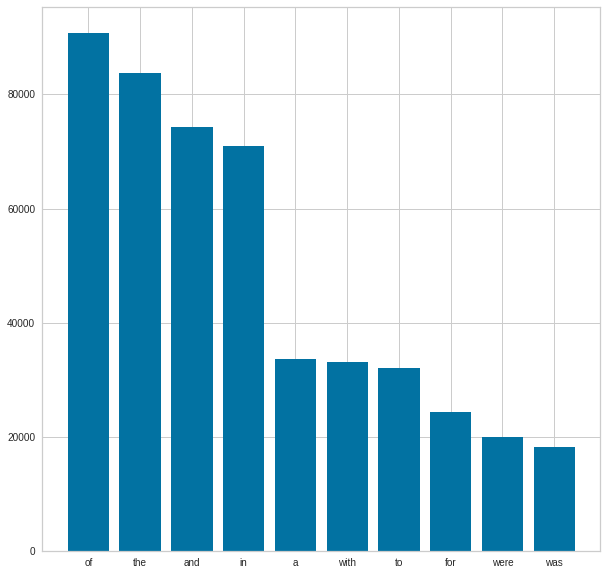

In [201]:
plot_top_stopwords_barchart(train['total'])

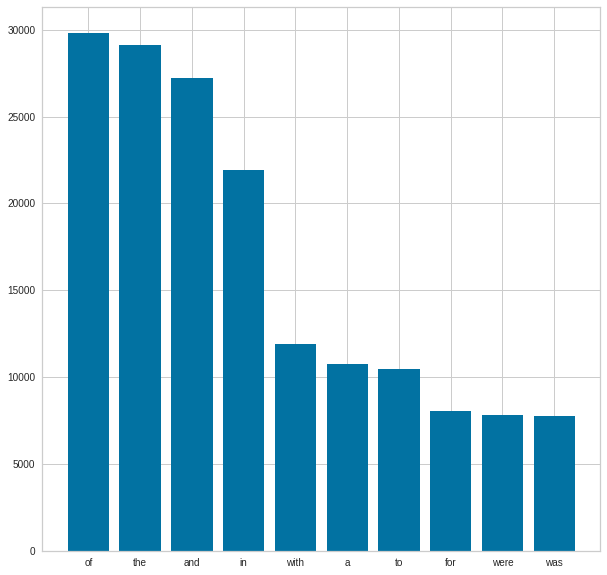

In [202]:
plot_top_stopwords_barchart(test['total'])

In [203]:
import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

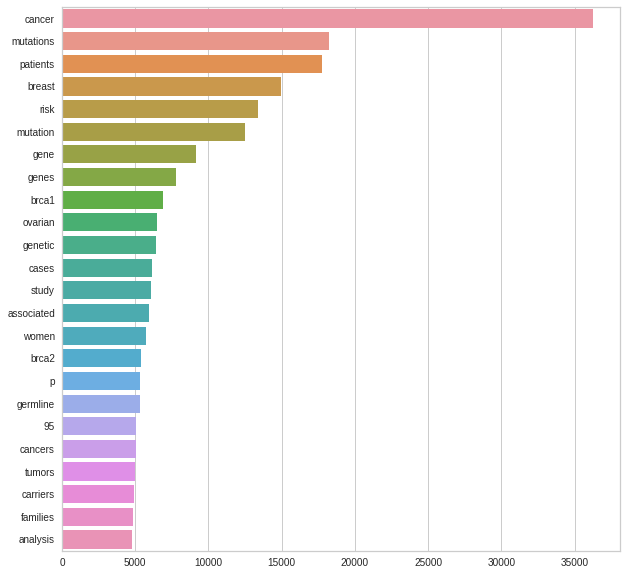

In [204]:
plot_top_non_stopwords_barchart(train['total'])

In [205]:
# Now we remove stopwords 

train['total_tokenize'] = train['total_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
train['total_tokenize_join'] = [' '.join(map(str, l)) for l in train['total_tokenize']]

train.head()

,pubmedid,Somatic,total,total_tokenize,total_tokenize_join
0,26182313,0,hereditary diffuse gastric cancer syndrome cdh...,"[hereditary, diffuse, gastric, cancer, syndrom...",hereditary diffuse gastric cancer syndrome cdh...
1,537637,0,cancer mortality among chinese japanese and in...,"[cancer, mortality, among, chinese, japanese, ...",cancer mortality among chinese japanese indian...
2,861471,0,relative risk of stump cancer following partia...,"[relative, risk, stump, cancer, following, par...",relative risk stump cancer following partial g...
3,1086044,0,endoscopic diagnosis of carcinoma in the opera...,"[endoscopic, diagnosis, carcinoma, operated, s...",endoscopic diagnosis carcinoma operated stomac...
4,31171120,0,hereditary cancer syndromesa primer on diagnos...,"[hereditary, cancer, syndromesa, primer, diagn...",hereditary cancer syndromesa primer diagnosis ...


In [206]:
#excel_writer = pd.ExcelWriter(r'/content/drive/MyDrive/results3.xlsx')
#train.to_excel(excel_writer, sheet_name='traindata')

#excel_writer.save()

In [207]:
test['total_tokenize'] = test['total_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
test['total_tokenize_join'] = [' '.join(map(str, l)) for l in test['total_tokenize']]

test.head()

,pubmedid,total,total_tokenize,total_tokenize_join
0,26649820,a mechanism for the suppression of homologous ...,"[mechanism, suppression, homologous, recombina...",mechanism suppression homologous recombination...
1,26654799,pancreatic cancer diagnostics and treatmentcur...,"[pancreatic, cancer, diagnostics, treatmentcur...",pancreatic cancer diagnostics treatmentcurrent...
2,26833090,noncatalytic roles for xpg with brca1 and brca...,"[noncatalytic, roles, xpg, brca1, brca2, homol...",noncatalytic roles xpg brca1 brca2 homologous ...
3,26845227,a rare case of familial multiple subcutaneous ...,"[rare, case, familial, multiple, subcutaneous,...",rare case familial multiple subcutaneous lipom...
4,26873923,targeting brca1 and brca2deficient cells with ...,"[targeting, brca1, brca2deficient, cells, rad5...",targeting brca1 brca2deficient cells rad52 sma...


In [208]:
# Let's evaluate the POS tags for our train set data
tagged_stanzas_train = []
tagged_train = []

for word in train['total_tokenize']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_train.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_train.append(tagged_stanzas_train)

In [209]:

# Let's evaluate the POS tags for our test set data
tagged_stanzas_test = []
tagged_test = []

for word in test['total_tokenize']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_test.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_test.append(tagged_stanzas_test)

In [210]:
!pip install -U yellowbrick

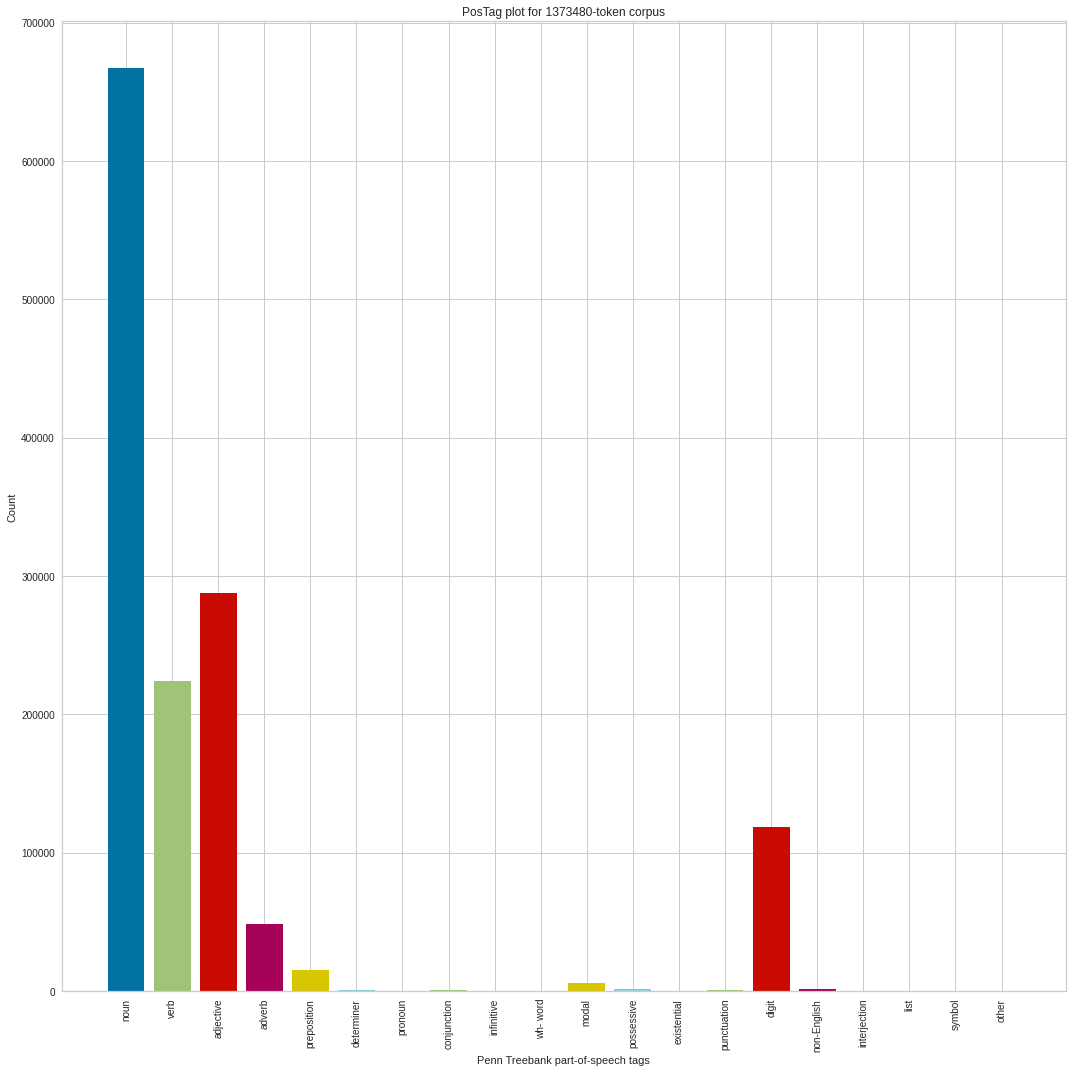

In [211]:
# Create the visualizer for train test

from yellowbrick.text import PosTagVisualizer
plt.figure(figsize=(15,15))
viz = PosTagVisualizer()
viz.fit(tagged_train)
viz.show()

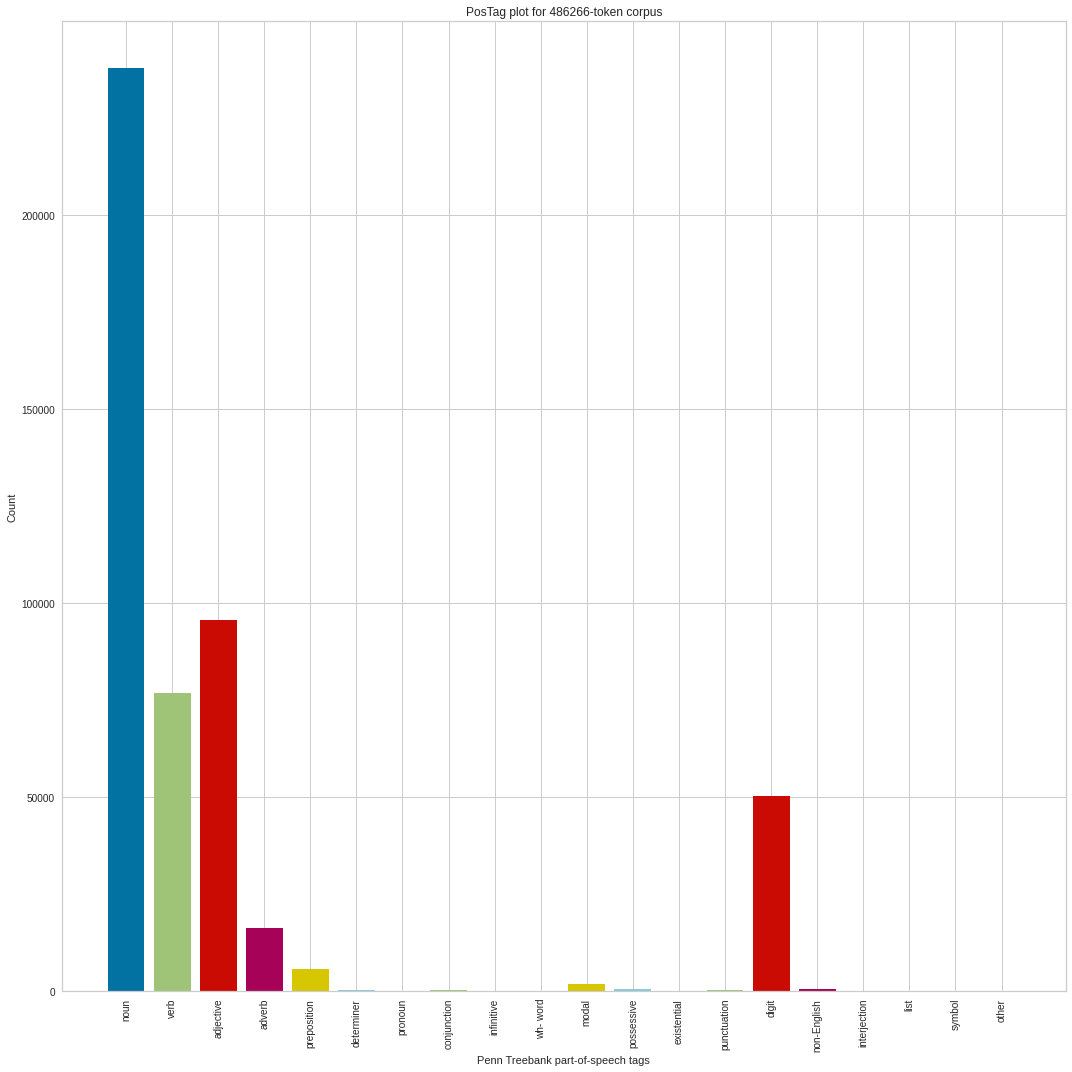

In [212]:
# Create the visualizer for test test

from yellowbrick.text import PosTagVisualizer
plt.figure(figsize=(15,15))
viz = PosTagVisualizer()
viz.fit(tagged_test)
viz.show()

In [213]:
# Now let's check if number of examples for fake vs not-fake label is equal or not. Seems like in this case it's very balanced. 

train.head()


,pubmedid,Somatic,total,total_tokenize,total_tokenize_join
0,26182313,0,hereditary diffuse gastric cancer syndrome cdh...,"[hereditary, diffuse, gastric, cancer, syndrom...",hereditary diffuse gastric cancer syndrome cdh...
1,537637,0,cancer mortality among chinese japanese and in...,"[cancer, mortality, among, chinese, japanese, ...",cancer mortality among chinese japanese indian...
2,861471,0,relative risk of stump cancer following partia...,"[relative, risk, stump, cancer, following, par...",relative risk stump cancer following partial g...
3,1086044,0,endoscopic diagnosis of carcinoma in the opera...,"[endoscopic, diagnosis, carcinoma, operated, s...",endoscopic diagnosis carcinoma operated stomac...
4,31171120,0,hereditary cancer syndromesa primer on diagnos...,"[hereditary, cancer, syndromesa, primer, diagn...",hereditary cancer syndromesa primer diagnosis ...


In [214]:
# Now let's check if number of examples for fake vs not-fake label is equal or not. Seems like in this case it's very balanced. 

train["Somatic"].value_counts()

0    5989
1    2643
Name: Somatic, dtype: int64

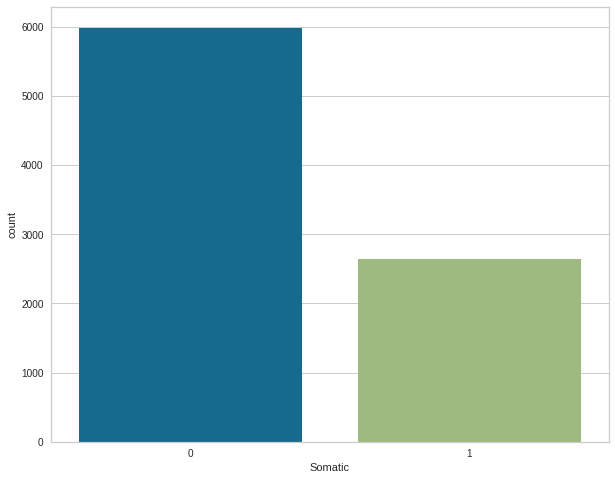

In [215]:
# we see there is an equal number of distribution of target features

rcParams["figure.figsize"] = 10,8
sns.countplot(x = train["Somatic"])

In [216]:
# lets extract the label column from train dataframe to be the target 'y' variable
targets = train['Somatic'].values

# Drop the 'label' column from train dataset
train.drop("Somatic", axis=1, inplace = True)
train.head()

,pubmedid,total,total_tokenize,total_tokenize_join
0,26182313,hereditary diffuse gastric cancer syndrome cdh...,"[hereditary, diffuse, gastric, cancer, syndrom...",hereditary diffuse gastric cancer syndrome cdh...
1,537637,cancer mortality among chinese japanese and in...,"[cancer, mortality, among, chinese, japanese, ...",cancer mortality among chinese japanese indian...
2,861471,relative risk of stump cancer following partia...,"[relative, risk, stump, cancer, following, par...",relative risk stump cancer following partial g...
3,1086044,endoscopic diagnosis of carcinoma in the opera...,"[endoscopic, diagnosis, carcinoma, operated, s...",endoscopic diagnosis carcinoma operated stomac...
4,31171120,hereditary cancer syndromesa primer on diagnos...,"[hereditary, cancer, syndromesa, primer, diagn...",hereditary cancer syndromesa primer diagnosis ...


In [217]:
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

In [218]:
# fit train data to the count vectorizer
train_counts = count_vectorizer.fit_transform(train['total'].values)

#fit the ngrams count to the tfidf transformers
train_tfidf = transformer.fit_transform(train_counts)

In [225]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

In [228]:
x = train['total'].values
#y = train['Somatic'].values

x_train, x_test, y_train, y_test = \
 train_test_split(x, targets, random_state=123)

In [226]:
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = \
# train_test_split(train_tfidf, targets, random_state=0 )

In [230]:

tokenizer = Tokenizer(num_words=100)
tokenizer.fit_on_texts(x)
xtrain= tokenizer.texts_to_sequences(x_train)
xtest= tokenizer.texts_to_sequences(x_test)

vocab_size=len(tokenizer.word_index)+1

maxlen=10
xtrain=pad_sequences(xtrain,padding='post', maxlen=maxlen)
xtest=pad_sequences(xtest,padding='post', maxlen=maxlen) 

 

print(x_train[3])
print(xtrain[3])

frequency of chek21100delc in new york breast cancer cases and controls the 1100delc chek2 allele has been associated with a 1447 fold increased risk for breast cancer in women carrying this mutation while the frequency of 1100delc was 1114 in healthy finnish controls the frequency of this allele in a north american control population and in north american breast cancer kindreds remains unclear we genotyped 1665 healthy new york volunteers and 300 cases of breast cancer for the chek21100delc the overall frequency of the 1100delc was 3300 10 among all cases with either a family history of breast cancer n  192 or a personal history of breast cancer n  108 of which 46 were bilateral 46 unilateral and 16 were male breast cancer cases compared to a frequency of 51665 03 in healthy controls p  01 there was no difference in allele frequency among ashkenazi and nonashkenazi controls the relatively low breast cancer penetrance of this allele along with the low population frequency will limit th

In [231]:
embedding_dim=50
model=Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
         output_dim=embedding_dim,
         input_length=maxlen))
model.add(layers.LSTM(units=50,return_sequences=True))
model.add(layers.LSTM(units=10))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", 
     metrics=['accuracy'])
model.summary()
model.fit(xtrain,y_train, epochs=20, batch_size=16, verbose=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 50)            2820800   
                                                                 
 lstm (LSTM)                 (None, 10, 50)            20200     
                                                                 
 lstm_1 (LSTM)               (None, 10)                2440      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 8)                 88        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,843,537
Trainable params: 2,843,537
Non-

In [232]:
loss, acc = model.evaluate(xtrain, y_train, verbose=False)
print("Training Accuracy: ", acc)
loss, acc = model.evaluate(xtest, y_test, verbose=False)
print("Test Accuracy: ", acc)

Training Accuracy:  0.7879208922386169
Test Accuracy:  0.754402220249176


In [ ]:
from sklearn.model_selection import train_test_split

#  If train-test size is not initialized, test_size will be set to 0.25 and train_set = 1-test_size

X_train, X_test, y_train, y_test = train_test_split(train_tfidf, targets, random_state=0)



In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
Extr = ExtraTreesClassifier(n_estimators=5,n_jobs=4)
Extr.fit(X_train, y_train)

print('Accuracy of ExtraTrees classifier on train set: {:.2f}'.format(Extr.score(X_train, y_train)))

print('Accuracy of ExtraTrees classifier on test set: {:.2f}'.format(Extr.score(X_test, y_test)))

Accuracy of ExtraTrees classifier on train set: 1.00
Accuracy of ExtraTrees classifier on test set: 0.81


In [ ]:
Adab= AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
Adab.fit(X_train, y_train)

print('Accuracy of Adaboost classifier on training set: {:.2f}'.format(Adab.score(X_train, y_train)))

print('Accuracy of Adaboost classifier on test set: {:.2f}'.format(Adab.score(X_test, y_test)))

Accuracy of Adaboost classifier on training set: 0.87
Accuracy of Adaboost classifier on test set: 0.86


In [ ]:
RandomFC= RandomForestClassifier(n_estimators=5)
RandomFC.fit(X_train, y_train)

print('Accuracy of randomforest classifier on training set: {:.2f}'.format(RandomFC.score(X_train, y_train)))

print('Accuracy of randomforest classifier on test set: {:.2f}'.format(RandomFC.score(X_test, y_test)))


Accuracy of randomforest classifier on training set: 0.98
Accuracy of randomforest classifier on test set: 0.82


In [ ]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)

print('Accuracy of NB  classifier on training set: {:.2f}'.format(NB.score(X_train, y_train)))

print('Accuracy of NB classifier on test set: {:.2f}'.format(NB.score(X_test, y_test)))

Accuracy of NB  classifier on training set: 0.72
Accuracy of NB classifier on test set: 0.69


In [ ]:
model = Sequential()
#model.add(LSTM(4, input_shape=(1, look_back)))
#model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
model.fit(X_train, y_train)
model.summary()

#print('Accuracy of NB  classifier on training set: {:.2f}'.format(model.score(X_train, y_train)))

#print('Accuracy of NB classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

203/203 [==============================] - 6s 20ms/step - loss: 0.1914
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 587107    
                                                                 
Total params: 587,107
Trainable params: 587,107
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(X_train, y_train)

print('Accuracy of sgd  classifier on training set: {:.2f}'.format(sgd.score(X_train, y_train)))

print('Accuracy of sgd classifier on test set: {:.2f}'.format(sgd.score(X_test, y_test)))

Accuracy of sgd  classifier on training set: 0.90
Accuracy of sgd classifier on test set: 0.86


In [ ]:
from sklearn import model_selection, svm
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train, y_train)

print('Accuracy of SVM  classifier on training set: {:.2f}'.format(SVM.score(X_train, y_train)))

print('Accuracy of SVM classifier on test set: {:.2f}'.format(SVM.score(X_test, y_test)))

Accuracy of SVM  classifier on training set: 0.98
Accuracy of SVM classifier on test set: 0.90


In [ ]:
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)

mlp.fit(X_train, y_train)

print('Accuracy of MLP  classifier on training set: {:.2f}'.format(mlp.score(X_train, y_train)))

print('Accuracy of MLP classifier on test set: {:.2f}'.format(mlp.score(X_test, y_test)))

Accuracy of MLP  classifier on training set: 1.00
Accuracy of MLP classifier on test set: 0.90


In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

print('Accuracy of Logreg classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))

print('Accuracy of Logreg classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logreg classifier on training set: 1.00
Accuracy of Logreg classifier on test set: 0.91


In [ ]:
# Use score method to get accuracy of model
score = logreg.score(X_test, y_test)
print(score)

0.906858202038925


In [ ]:
# Predict and calculate accuracy
from sklearn.metrics import accuracy_score

predictions = logreg.predict(X_test)
score=accuracy_score(y_test,predictions)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 90.69%


In [ ]:
from sklearn import metrics

CM = metrics.confusion_matrix(y_test, predictions)
print(CM)

[[1431   54]
 [ 147  526]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [ ]:
print('Recall: %.2f' % recall_score(y_test, predictions))
print('Accuracy: %.2f' % accuracy_score(y_test, predictions))
print('F1 Score: %.2f' % f1_score(y_test, predictions))

Recall: 0.78
Accuracy: 0.91
F1 Score: 0.84


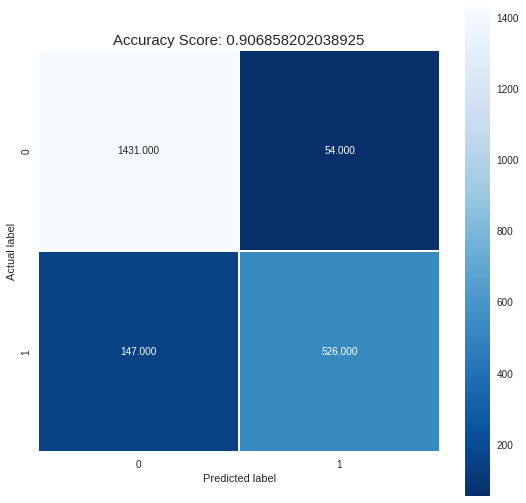

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(CM, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [ ]:
logreg.fit(train_counts, targets)

test_counts = count_vectorizer.transform(test['total'].values)
test_pred = logreg.predict(test_counts)

pred=pd.DataFrame(test_pred, columns=['test_label'])
pred['pubmedid']=test['pubmedid']
pred.groupby('test_label').count()

,pubmedid
test_label,
0,2338
1,562


In [ ]:
excel_writer = pd.ExcelWriter(r'/content/drive/MyDrive/results1.xlsx')
pred.to_excel(excel_writer, sheet_name='prediction')

excel_writer.save()